In [2]:
# essentials
import pandas as pd
import numpy as np

# models and training

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import AgglomerativeClustering

# visualization
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import math
from collections import Counter
import itertools


from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
labels = pd.read_csv("/content/drive/MyDrive/ML/ML_Data G1/dataset/label/labels.csv",names=['labels'])
melMFCC = pd.read_csv("/content/drive/MyDrive/ML/ML_Data G1/dataset/melMFCC (3).csv")
cwt = pd.read_csv("/content/drive/MyDrive/ML/ML_Data G1/dataset/cwt.csv")
spectrum = pd.read_csv("/content/drive/MyDrive/ML/ML_Data G1/dataset/spectrum.csv")
zcrossRMS = pd.read_csv("/content/drive/MyDrive/ML/ML_Data G1/dataset/zcrossRMS.csv")
data = pd.concat([melMFCC, cwt, spectrum, zcrossRMS], axis=1)

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
imputer.fit(data)
data[:] = imputer.transform(data)

In [5]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data)
dataset =  scaler.transform(data)

In [7]:

### ELbow Method 


distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(data)
    kmeanModel.fit(data)
    pred_label = kmeanModel.labels_

    distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / data.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / data.shape[0]
    mapping2[k] = kmeanModel.inertia_




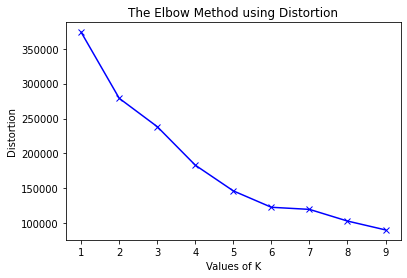

In [8]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [9]:
# True pos, True neg, False pos, False neg




def combination(n,k):
    return (math.factorial(n))/((math.factorial(n-k))*math.factorial(k))


def tp_fp_tn_fn(y_predict,y_test):
    length_ = len(y_test)
    cluster = {i:[] for i in set(y_predict)}


    for i,j in zip(y_predict,y_test):
        cluster[i].append(j)
    

    cluster_count = {i:dict(Counter(j)) for i,j in zip(list(cluster.keys()),list(cluster.values()))}


    tp_fp = 0
    for i in list(cluster_count.keys()):  
        if sum(cluster_count[i].values()) >= 2:
            tp_fp += combination(sum(cluster_count[i].values()),2)

    tp = 0
    Tp_anyclass = {i:0 for i in set(y_test)}
    for i in list(cluster_count.keys()):
        for j in list(cluster_count[i].keys()):
            if cluster_count[i][j] >1 : 
                temp = combination(cluster_count[i][j],2)
                tp +=temp
                Tp_anyclass[j] +=temp
     

    fp = tp_fp - tp
    
    class_fn = {i:[] for i in set(y_test)}
    
    for i in list(cluster_count.keys()):
        for j in list(cluster_count[i].keys()):
            class_fn[j].append(cluster_count[i][j])
            
    total_fn = 0 
    fn_anyclass = {i:0 for i in set(y_test)}
    for i in list(class_fn.keys()):
        data = itertools.combinations(set(class_fn[i]), 2)
        my_Set = list(data)
        fn =0 
        for j in my_Set:
            fn+= j[0] * j[1]
        fn_anyclass[i] =fn 
        total_fn += fn    
    
    
    tn = combination(length_,2) - tp_fp - total_fn
    
    return tp , fp ,total_fn ,tn,fn_anyclass,Tp_anyclass


def f1_score(tp,fp,tn,fn):
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*precision*recall)/(precision+recall)
    return f1



from collections import Counter

def purity(labels, clustered):
    
    cluster_ids = set(clustered)
    
    N = len(clustered)
    
    majority_sum = 0  
    for cl in cluster_ids:

        labels_cl = Counter(l for l, c in zip(labels, clustered) if c == cl)
        majority_sum += max(labels_cl.values())

    return majority_sum / N



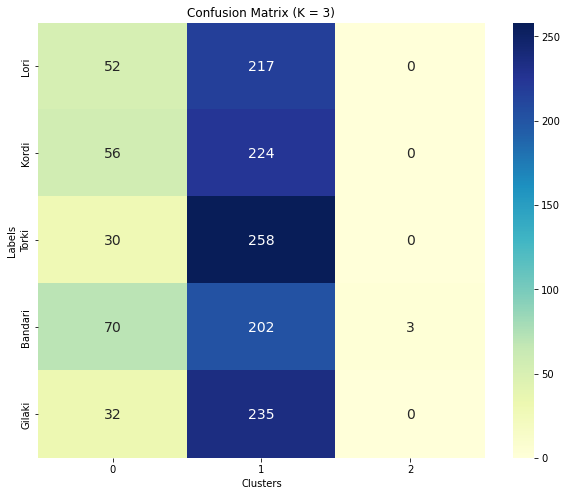

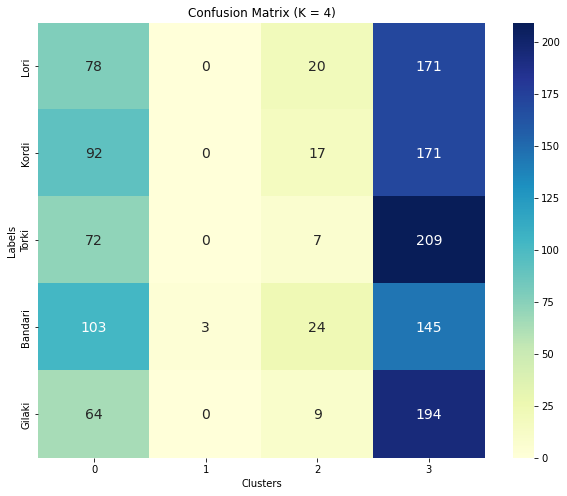

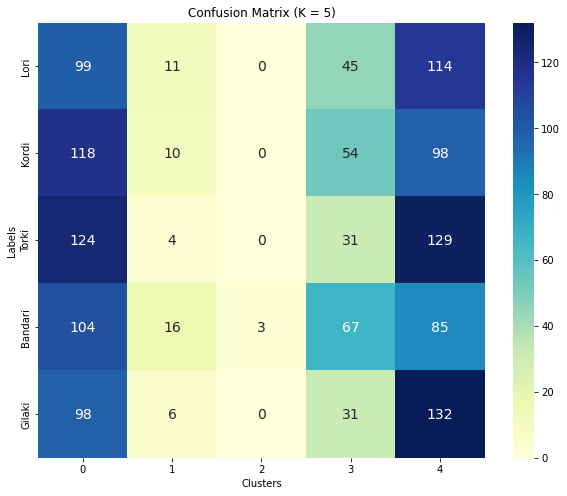

In [32]:
from sklearn.metrics.cluster import rand_score

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


randscore = []
f1score = [] 
pu = []


K = range(1, 6)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(data)
    kmeanModel.fit(data)
    pred_label = kmeanModel.labels_

    randscore.append(rand_score(list(labels['labels']), pred_label))
    tp , fp ,fn ,tn,fn_anyclass,Tp_anyclass = tp_fp_tn_fn(list(labels['labels']), pred_label)

    if k>=3: 
      fig, ax = plt.subplots(figsize = (10,8))
      df = pd.DataFrame({'Labels': list(labels['labels']), 'Clusters': pred_label})
      # Create crosstab: ct
      ct = pd.crosstab(df['Labels'], df['Clusters'])
      sns.heatmap(ct, annot=True, annot_kws={"size": 14},cmap="YlGnBu", fmt='g');
      ax.set_title("Confusion Matrix (K = {})".format(k))
      ax.yaxis.set_ticklabels(['Lori', 'Kordi', 'Torki', 'Bandari', 'Gilaki']);

    f1score.append(f1_score(tp,fp,tn,fn))
    pu.append(purity(list(labels['labels']), pred_label))

In [33]:
kmenas_result_Df = pd.DataFrame()
kmenas_result_Df['purity'] = pu

kmenas_result_Df['randscore'] =randscore
kmenas_result_Df['f1score'] = f1score
kmenas_result_Df


,purity,randscore,f1score
0,0.208847,0.199572,0.332739
1,0.227701,0.302613,0.323365
2,0.240029,0.377106,0.314203
3,0.245830,0.498696,0.355945
4,0.248006,0.594565,0.261041


In [ ]:
from sklearn.decomposition import PCA
pca_2d = PCA(n_components=2)

AgglomerativeClustering

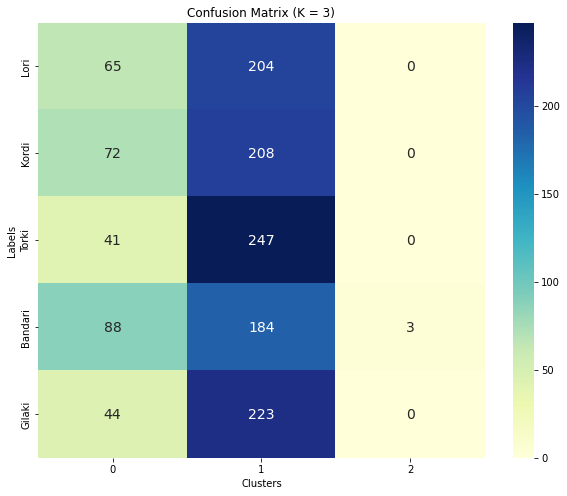

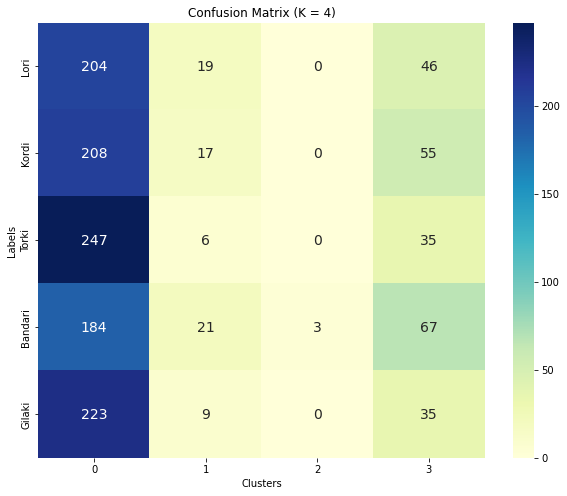

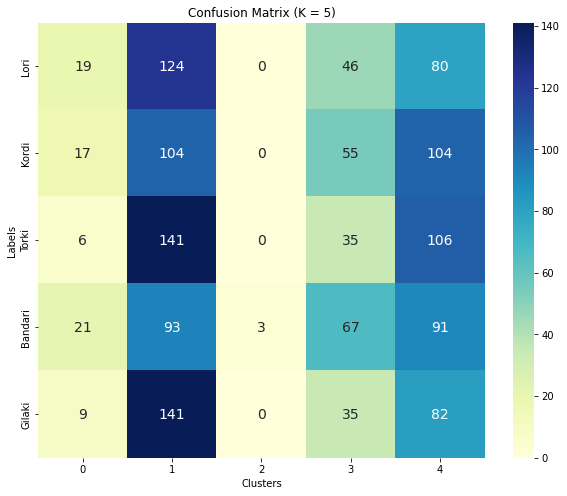

In [35]:

randscore = []
f1score = [] 
pu = []


K = range(1, 6)
 
for k in K:
    # Building and fitting the model
    model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    pred_label = model.fit_predict(data)
    

    randscore.append(rand_score(list(labels['labels']), pred_label))
    tp , fp ,fn ,tn,fn_anyclass,Tp_anyclass = tp_fp_tn_fn(list(labels['labels']), pred_label)

    if k>=3: 
      fig, ax = plt.subplots(figsize = (10,8))
      df = pd.DataFrame({'Labels': list(labels['labels']), 'Clusters': pred_label})
      # Create crosstab: ct
      ct = pd.crosstab(df['Labels'], df['Clusters'])
      sns.heatmap(ct, annot=True, annot_kws={"size": 14},cmap="YlGnBu", fmt='g');
      ax.set_title("Confusion Matrix (K = {})".format(k))
      ax.yaxis.set_ticklabels(['Lori', 'Kordi', 'Torki', 'Bandari', 'Gilaki']);

    f1score.append(f1_score(tp,fp,tn,fn))
    pu.append(purity(list(labels['labels']), pred_label))






In [36]:
AgglomerativeClustering_DF = pd.DataFrame()
AgglomerativeClustering_DF['purity'] = pu

AgglomerativeClustering_DF['randscore'] =randscore
AgglomerativeClustering_DF['f1score'] = f1score
AgglomerativeClustering_DF


,purity,randscore,f1score
0,0.208847,0.199572,0.332739
1,0.245105,0.414090,0.309396
2,0.245105,0.414513,0.309098
3,0.245105,0.424674,0.309112
4,0.245105,0.601255,0.297711
